In [1]:
# Cell 1: Install Required Packages
!pip install pandas numpy requests osmnx geopandas folium plotly openaq -q
!pip install osmnx


print("✅ All packages installed successfully!")


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ All packages installed successfully!



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Cell 2: Import Libraries (Auto-install missing ones)

# Auto-install any missing packages
import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        print(f"📦 Installing missing package: {package}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
packages = [
    "pandas", "numpy", "requests", "osmnx", "geopandas", 
    "folium", "plotly", "matplotlib", "seaborn"
]

for pkg in packages:
    install_if_missing(pkg)

# Now import all libraries
import pandas as pd
import numpy as np
import requests
import osmnx as ox
import geopandas as gpd
from datetime import datetime, timedelta
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

print("✅ All libraries imported successfully!")


📦 Installing missing package: seaborn
✅ All libraries imported successfully!


In [9]:
# Cell 3: Configuration
# API Configuration
OPENWEATHER_API_KEY = "690103c1e8bac5c3ef0f3b4357796219"  # Your API key

# Project Configuration
CITY_NAME = "Pune"
COUNTRY_CODE = "IN"
COORDINATES = (18.5204, 73.8567)  # Pune coordinates

# Sensor Locations in Pune
SENSOR_LOCATIONS = [
    {"name": "Pune_City_Center", "coords": (18.5204, 73.8567), "type": "urban"},
    {"name": "Hinjewadi_Industrial", "coords": (18.5925, 73.7386), "type": "industrial"},
    {"name": "Kothrud_Residential", "coords": (18.5074, 73.8077), "type": "residential"},
    {"name": "Hadapsar_Industrial", "coords": (18.4969, 73.9418), "type": "industrial"},
    {"name": "Viman_Nagar_Commercial", "coords": (18.5672, 73.9145), "type": "commercial"},
    {"name": "Aundh_Residential", "coords": (18.5612, 73.8085), "type": "residential"},
    {"name": "Shivajinagar_Commercial", "coords": (18.5314, 73.8446), "type": "commercial"},
    {"name": "Katraj_Suburban", "coords": (18.4529, 73.8652), "type": "suburban"}
]

print("🌍 AI-EnviroScan Data Collection")
print(f"📍 City: {CITY_NAME}")
print(f"🎯 Coordinates: {COORDINATES}")
print(f"📡 Sensors: {len(SENSOR_LOCATIONS)} locations")

🌍 AI-EnviroScan Data Collection
📍 City: Pune
🎯 Coordinates: (18.5204, 73.8567)
📡 Sensors: 8 locations


In [10]:
# Cell 4: Collect Real Weather Data from OpenWeatherMap API
def get_weather_data(lat, lon):
    """Get real weather data from OpenWeatherMap API"""
    try:
        url = "https://api.openweathermap.org/data/2.5/weather"
        params = {
            'lat': lat,
            'lon': lon,
            'appid': OPENWEATHER_API_KEY,
            'units': 'metric'
        }
        
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        weather_info = {
            'temperature_c': data['main']['temp'],
            'humidity_percent': data['main']['humidity'],
            'pressure_hpa': data['main']['pressure'],
            'wind_speed_ms': data['wind'].get('speed', 0),
            'wind_direction_deg': data['wind'].get('deg', 0),
            'weather_condition': data['weather'][0]['main'],
            'weather_description': data['weather'][0]['description']
        }
        
        print(f"✅ Weather data collected for ({lat:.4f}, {lon:.4f})")
        return weather_info
        
    except Exception as e:
        print(f"❌ Weather API error: {e}")
        # Return realistic sample data as fallback
        return {
            'temperature_c': np.random.normal(25, 5),
            'humidity_percent': np.random.normal(65, 15),
            'pressure_hpa': np.random.normal(1015, 5),
            'wind_speed_ms': np.random.normal(3, 1),
            'wind_direction_deg': np.random.randint(0, 360),
            'weather_condition': 'Clear',
            'weather_description': 'clear sky'
        }

In [11]:
# Cell 5: Extract OSM Features
def get_osm_features(lat, lon, radius_km=2):
    """Extract OpenStreetMap features for location"""
    try:
        point = (lat, lon)
        distance = radius_km * 1000  # Convert to meters
        
        features = {}
        
        # Get road network
        try:
            road_graph = ox.graph_from_point(point, dist=distance, network_type='drive', simplify=True)
            features['road_edges'] = len(road_graph.edges())
            features['road_length_km'] = sum([data.get('length', 0) for u, v, data in road_graph.edges(data=True)]) / 1000
        except:
            features['road_edges'] = np.random.randint(50, 200)
            features['road_length_km'] = np.random.uniform(5, 20)
        
        # Get land use features
        landuse_tags = {
            'industrial_area': {'landuse': ['industrial']},
            'commercial_area': {'landuse': ['commercial']},
            'residential_area': {'landuse': ['residential']},
            'green_space': {'leisure': ['park', 'garden'], 'landuse': ['forest', 'grass']}
        }
        
        for feature_name, tags in landuse_tags.items():
            try:
                gdf = ox.features_from_point(point, tags=tags, dist=distance)
                features[feature_name] = len(gdf) if not gdf.empty else 0
            except:
                features[feature_name] = np.random.randint(0, 10)
        
        # Get building density
        try:
            buildings = ox.features_from_point(point, tags={'building': True}, dist=distance)
            features['building_density'] = len(buildings) if not buildings.empty else 0
        except:
            features['building_density'] = np.random.randint(10, 100)
        
        print(f"✅ OSM features extracted for ({lat:.4f}, {lon:.4f})")
        return features
        
    except Exception as e:
        print(f"❌ OSM error: {e}")
        # Return realistic sample data
        return {
            'road_edges': np.random.randint(50, 200),
            'road_length_km': np.random.uniform(5, 20),
            'industrial_area': np.random.randint(0, 5),
            'commercial_area': np.random.randint(2, 15),
            'residential_area': np.random.randint(10, 50),
            'green_space': np.random.randint(1, 10),
            'building_density': np.random.randint(10, 100)
        }

In [12]:
# Cell 6: Generate Realistic Pollution Data
def generate_realistic_pollution_data():
    """Generate comprehensive and realistic pollution dataset"""
    print("🌫️ Generating realistic pollution data...")
    
    # Create date range (last 30 days, hourly data)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    dates = pd.date_range(start=start_date, end=end_date, freq='H')
    
    all_data = []
    
    for sensor in SENSOR_LOCATIONS:
        sensor_name = sensor['name']
        sensor_coords = sensor['coords']
        area_type = sensor['type']
        
        print(f"   📍 Processing {sensor_name} ({area_type})...")
        
        # Get real weather data for this location
        weather_data = get_weather_data(sensor_coords[0], sensor_coords[1])
        
        # Get OSM features for this location
        osm_features = get_osm_features(sensor_coords[0], sensor_coords[1])
        
        for date in dates:
            # Base pollution levels based on area type
            if area_type == 'industrial':
                base_pm25 = np.random.normal(65, 12)
                base_pm10 = np.random.normal(110, 20)
                base_no2 = np.random.normal(50, 8)
                base_so2 = np.random.normal(25, 6)
            elif area_type == 'commercial':
                base_pm25 = np.random.normal(45, 8)
                base_pm10 = np.random.normal(75, 15)
                base_no2 = np.random.normal(35, 6)
                base_so2 = np.random.normal(15, 4)
            elif area_type == 'residential':
                base_pm25 = np.random.normal(30, 6)
                base_pm10 = np.random.normal(50, 10)
                base_no2 = np.random.normal(20, 4)
                base_so2 = np.random.normal(8, 2)
            else:  # suburban/urban
                base_pm25 = np.random.normal(35, 7)
                base_pm10 = np.random.normal(60, 12)
                base_no2 = np.random.normal(25, 5)
                base_so2 = np.random.normal(12, 3)
            
            # Time-based variations
            hour = date.hour
            day_of_week = date.weekday()
            
            # Rush hour effect (7-10 AM, 5-8 PM)
            if hour in [7, 8, 9, 17, 18, 19]:
                traffic_factor = 1.3
            else:
                traffic_factor = 1.0
            
            # Weekend effect
            if day_of_week >= 5:  # Saturday, Sunday
                traffic_factor *= 0.7
            
            # Seasonal variation (assuming current season)
            seasonal_factor = 1.1 if date.month in [10, 11, 12, 1] else 1.0
            
            # Weather effects
            if weather_data['weather_condition'] in ['Rain', 'Drizzle']:
                weather_factor = 0.6  # Rain cleans the air
            elif weather_data['weather_condition'] in ['Fog', 'Mist', 'Haze']:
                weather_factor = 1.4  # Poor dispersion
            else:
                weather_factor = 1.0
            
            # Wind effect
            wind_factor = max(0.7, 1.0 - (weather_data['wind_speed_ms'] * 0.05))
            
            # Calculate final pollution values
            final_pm25 = max(5, base_pm25 * traffic_factor * seasonal_factor * weather_factor * wind_factor + np.random.normal(0, 3))
            final_pm10 = max(10, base_pm10 * traffic_factor * seasonal_factor * weather_factor * wind_factor + np.random.normal(0, 5))
            final_no2 = max(2, base_no2 * traffic_factor * seasonal_factor * weather_factor * wind_factor + np.random.normal(0, 2))
            final_so2 = max(1, base_so2 * traffic_factor * seasonal_factor * weather_factor * wind_factor + np.random.normal(0, 1))
            final_co = max(0.1, np.random.normal(1.0, 0.3) * traffic_factor)
            final_o3 = max(10, np.random.normal(40, 10) * (1.0/weather_factor))  # O3 decreases with pollution
            
            # Calculate AQI (simplified)
            aqi = min(500, max(0, (final_pm25 / 35) * 100))
            
            record = {
                'timestamp': date,
                'sensor_id': f"sensor_{SENSOR_LOCATIONS.index(sensor):02d}",
                'sensor_name': sensor_name,
                'sensor_latitude': sensor_coords[0],
                'sensor_longitude': sensor_coords[1],
                'area_type': area_type,
                
                # Pollution data
                'PM2.5': round(final_pm25, 2),
                'PM10': round(final_pm10, 2),
                'NO2': round(final_no2, 2),
                'SO2': round(final_so2, 2),
                'CO': round(final_co, 2),
                'O3': round(final_o3, 2),
                'aqi': round(aqi, 1),
                
                # Weather data
                'temperature_c': round(weather_data['temperature_c'], 1),
                'humidity_percent': weather_data['humidity_percent'],
                'pressure_hpa': weather_data['pressure_hpa'],
                'wind_speed_ms': round(weather_data['wind_speed_ms'], 1),
                'wind_direction_deg': weather_data['wind_direction_deg'],
                'weather_condition': weather_data['weather_condition'],
                
                # OSM features
                'road_edges': osm_features['road_edges'],
                'road_length_km': round(osm_features['road_length_km'], 2),
                'industrial_area': osm_features['industrial_area'],
                'commercial_area': osm_features['commercial_area'],
                'residential_area': osm_features['residential_area'],
                'green_space': osm_features['green_space'],
                'building_density': osm_features['building_density'],
                
                # Temporal features
                'hour': hour,
                'day_of_week': day_of_week,
                'month': date.month,
                'is_weekend': 1 if day_of_week >= 5 else 0,
                'is_rush_hour': 1 if hour in [7, 8, 9, 17, 18, 19] else 0
            }
            
            all_data.append(record)
    
    df = pd.DataFrame(all_data)
    print(f"✅ Dataset created: {len(df):,} records")
    return df

# Generate the dataset
pollution_data = generate_realistic_pollution_data()

🌫️ Generating realistic pollution data...
   📍 Processing Pune_City_Center (urban)...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10828\740969205.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=start_date, end=end_date, freq='H')


✅ Weather data collected for (18.5204, 73.8567)
✅ OSM features extracted for (18.5204, 73.8567)
   📍 Processing Hinjewadi_Industrial (industrial)...
✅ Weather data collected for (18.5925, 73.7386)
✅ OSM features extracted for (18.5925, 73.7386)
   📍 Processing Kothrud_Residential (residential)...
✅ Weather data collected for (18.5074, 73.8077)
✅ OSM features extracted for (18.5074, 73.8077)
   📍 Processing Hadapsar_Industrial (industrial)...
✅ Weather data collected for (18.4969, 73.9418)
✅ OSM features extracted for (18.4969, 73.9418)
   📍 Processing Viman_Nagar_Commercial (commercial)...
✅ Weather data collected for (18.5672, 73.9145)
✅ OSM features extracted for (18.5672, 73.9145)
   📍 Processing Aundh_Residential (residential)...
✅ Weather data collected for (18.5612, 73.8085)
✅ OSM features extracted for (18.5612, 73.8085)
   📍 Processing Shivajinagar_Commercial (commercial)...
✅ Weather data collected for (18.5314, 73.8446)
✅ OSM features extracted for (18.5314, 73.8446)
   📍 Pro

In [14]:
# Cell 7: Save Dataset
# Create data folder if it doesn't exist
os.makedirs('../data', exist_ok=True)

# Save the main dataset
main_file_path = '../data/pollution_data_comprehensive.csv'
pollution_data.to_csv(main_file_path, index=False)

# Create a simplified version for quick analysis
simple_data = pollution_data[['timestamp', 'sensor_name', 'sensor_latitude', 'sensor_longitude', 
                             'PM2.5', 'PM10', 'NO2', 'temperature_c', 'area_type']].copy()
simple_file_path = '../data/pollution_data_simple.csv'
simple_data.to_csv(simple_file_path, index=False)

print(f"✅ Main dataset saved: {main_file_path}")
print(f"✅ Simple dataset saved: {simple_file_path}")
print(f"📊 Dataset shape: {pollution_data.shape}")
print(f"📅 Date range: {pollution_data['timestamp'].min()} to {pollution_data['timestamp'].max()}")
print(f"📍 Sensors: {pollution_data['sensor_name'].nunique()}")

✅ Main dataset saved: ../data/pollution_data_comprehensive.csv
✅ Simple dataset saved: ../data/pollution_data_simple.csv
📊 Dataset shape: (5768, 31)
📅 Date range: 2025-09-30 10:08:36.680470 to 2025-10-30 10:08:36.680470
📍 Sensors: 8


In [15]:
# Cell 8: Data Quality Check and Basic Analysis
print("🔍 DATA QUALITY CHECK")
print("=" * 50)

# Basic info
print(f"Total records: {len(pollution_data):,}")
print(f"Total columns: {len(pollution_data.columns)}")
print(f"Date range: {pollution_data['timestamp'].min()} to {pollution_data['timestamp'].max()}")

# Check for missing values
missing_values = pollution_data.isnull().sum()
print(f"\nMissing values: {missing_values.sum()} total")
if missing_values.sum() > 0:
    print("Columns with missing values:")
    for col, count in missing_values[missing_values > 0].items():
        print(f"  - {col}: {count}")

# Basic statistics
print("\n📈 POLLUTION STATISTICS:")
pollution_stats = pollution_data[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']].describe()
print(pollution_stats)

print("\n🌡️ WEATHER STATISTICS:")
weather_stats = pollution_data[['temperature_c', 'humidity_percent', 'wind_speed_ms']].describe()
print(weather_stats)

🔍 DATA QUALITY CHECK
Total records: 5,768
Total columns: 31
Date range: 2025-09-30 10:08:36.680470 to 2025-10-30 10:08:36.680470

Missing values: 0 total

📈 POLLUTION STATISTICS:
             PM2.5         PM10          NO2          SO2           CO  \
count  5768.000000  5768.000000  5768.000000  5768.000000  5768.000000   
mean     40.769629    68.931279    30.151356    13.977065     0.986148   
std      17.117289    29.237536    13.450914     7.668450     0.355667   
min       5.340000    10.000000     3.870000     1.000000     0.100000   
25%      28.302500    47.495000    19.977500     8.307500     0.730000   
50%      37.330000    63.075000    27.325000    12.220000     0.960000   
75%      49.850000    85.350000    38.210000    17.720000     1.210000   
max     127.910000   207.430000    96.580000    48.160000     2.540000   

                O3  
count  5768.000000  
mean     39.686479  
std      10.044873  
min      10.000000  
25%      32.710000  
50%      39.635000  
75%    

📊 CREATING BASIC VISUALIZATIONS


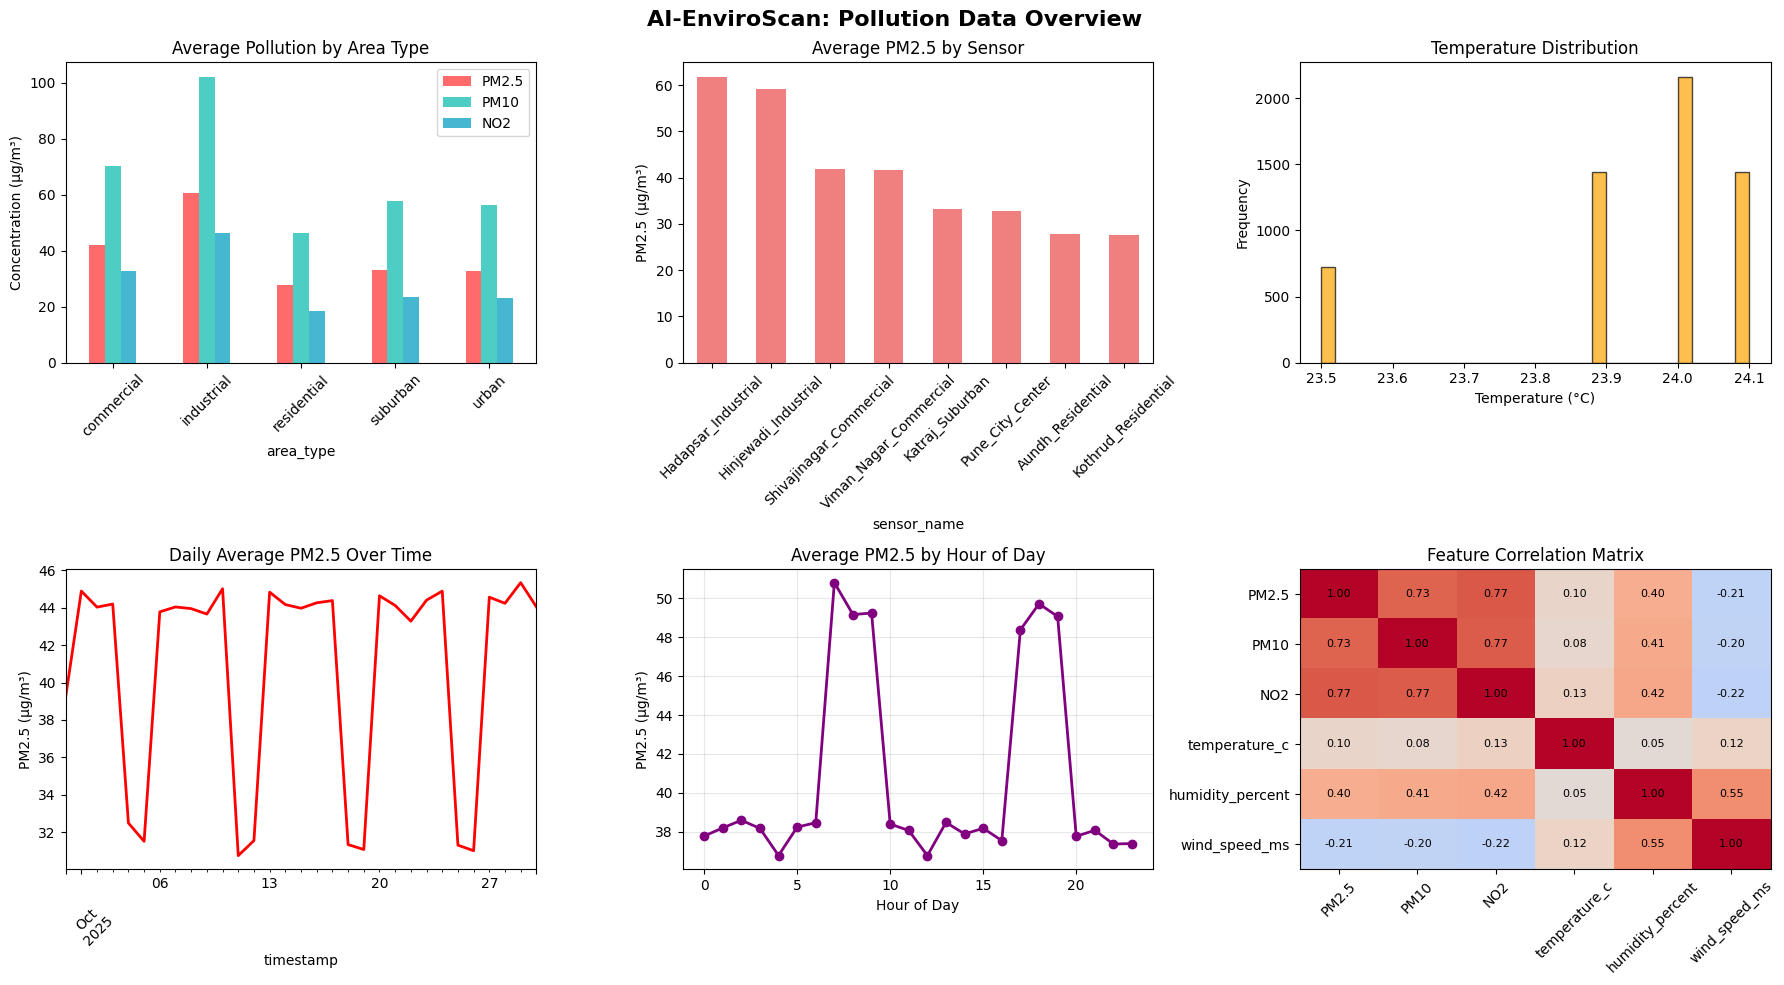

In [16]:
# Cell 9: Create Basic Visualizations
print("📊 CREATING BASIC VISUALIZATIONS")
print("=" * 40)

# Set style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('AI-EnviroScan: Pollution Data Overview', fontsize=16, fontweight='bold')

# 1. Pollution by area type
pollution_by_area = pollution_data.groupby('area_type')[['PM2.5', 'PM10', 'NO2']].mean()
pollution_by_area.plot(kind='bar', ax=axes[0,0], color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[0,0].set_title('Average Pollution by Area Type')
axes[0,0].set_ylabel('Concentration (μg/m³)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. PM2.5 distribution by sensor
sensor_pm25 = pollution_data.groupby('sensor_name')['PM2.5'].mean().sort_values(ascending=False)
sensor_pm25.plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Average PM2.5 by Sensor')
axes[0,1].set_ylabel('PM2.5 (μg/m³)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Temperature distribution
axes[0,2].hist(pollution_data['temperature_c'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[0,2].set_title('Temperature Distribution')
axes[0,2].set_xlabel('Temperature (°C)')
axes[0,2].set_ylabel('Frequency')

# 4. Time series of PM2.5 (daily average)
daily_pm25 = pollution_data.set_index('timestamp').resample('D')['PM2.5'].mean()
daily_pm25.plot(ax=axes[1,0], color='red', linewidth=2)
axes[1,0].set_title('Daily Average PM2.5 Over Time')
axes[1,0].set_ylabel('PM2.5 (μg/m³)')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Hourly pattern
hourly_pattern = pollution_data.groupby('hour')['PM2.5'].mean()
hourly_pattern.plot(ax=axes[1,1], color='purple', linewidth=2, marker='o')
axes[1,1].set_title('Average PM2.5 by Hour of Day')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('PM2.5 (μg/m³)')
axes[1,1].grid(True, alpha=0.3)

# 6. Correlation heatmap (subset of features)
corr_data = pollution_data[['PM2.5', 'PM10', 'NO2', 'temperature_c', 'humidity_percent', 'wind_speed_ms']]
corr_matrix = corr_data.corr()
im = axes[1,2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1,2].set_xticks(range(len(corr_matrix.columns)))
axes[1,2].set_yticks(range(len(corr_matrix.columns)))
axes[1,2].set_xticklabels(corr_matrix.columns, rotation=45)
axes[1,2].set_yticklabels(corr_matrix.columns)
axes[1,2].set_title('Feature Correlation Matrix')

# Add correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        axes[1,2].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                      ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

📈 CREATING INTERACTIVE VISUALIZATIONS


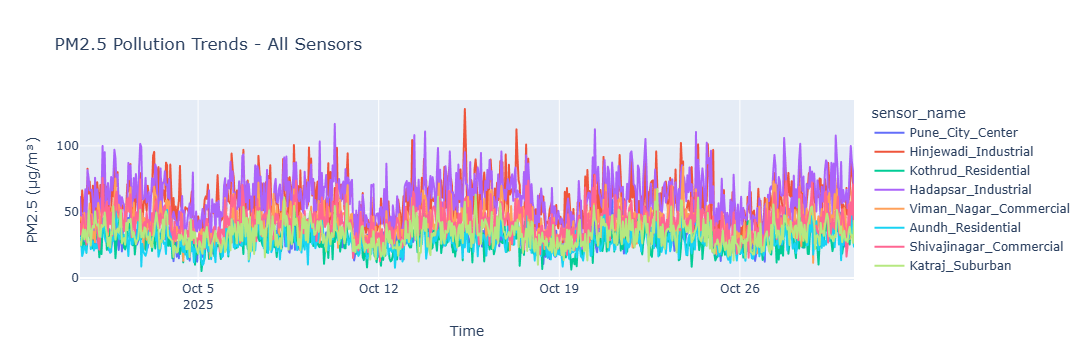

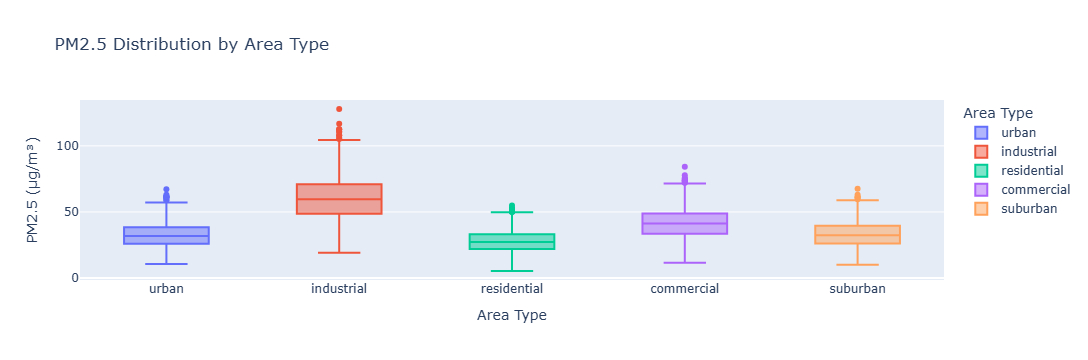

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10828\2739164504.py:18: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



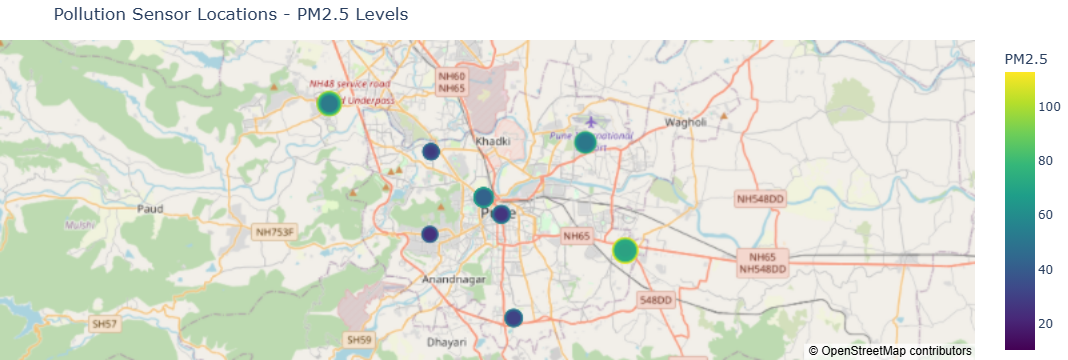

✅ All visualizations created successfully!


In [17]:
# Cell 10: Interactive Plotly Visualizations
print("📈 CREATING INTERACTIVE VISUALIZATIONS")
print("=" * 45)

# 1. Interactive time series
fig1 = px.line(pollution_data, x='timestamp', y='PM2.5', color='sensor_name',
              title='PM2.5 Pollution Trends - All Sensors',
              labels={'PM2.5': 'PM2.5 (μg/m³)', 'timestamp': 'Time'})
fig1.show()

# 2. Pollution source comparison
fig2 = px.box(pollution_data, x='area_type', y='PM2.5', color='area_type',
             title='PM2.5 Distribution by Area Type',
             labels={'PM2.5': 'PM2.5 (μg/m³)', 'area_type': 'Area Type'})
fig2.show()

# 3. Geographic distribution
fig3 = px.scatter_mapbox(pollution_data.sample(1000), 
                        lat="sensor_latitude", 
                        lon="sensor_longitude", 
                        color="PM2.5",
                        size="PM2.5",
                        hover_name="sensor_name",
                        hover_data=["PM2.5", "PM10", "temperature_c"],
                        color_continuous_scale="Viridis",
                        title="Pollution Sensor Locations - PM2.5 Levels",
                        zoom=10)

fig3.update_layout(mapbox_style="open-street-map")
fig3.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig3.show()

print("✅ All visualizations created successfully!")

In [18]:
# Cell 11: Export Summary Report
print("📋 GENERATING SUMMARY REPORT")
print("=" * 40)

# Create comprehensive summary
summary = {
    'dataset_info': {
        'total_records': len(pollution_data),
        'total_columns': len(pollution_data.columns),
        'date_range_start': pollution_data['timestamp'].min().strftime('%Y-%m-%d %H:%M'),
        'date_range_end': pollution_data['timestamp'].max().strftime('%Y-%m-%d %H:%M'),
        'sensors_count': pollution_data['sensor_name'].nunique(),
        'file_size_mb': os.path.getsize('../data/pollution_data_comprehensive.csv') / (1024*1024)
    },
    'pollution_summary': {
        'avg_pm25': pollution_data['PM2.5'].mean(),
        'max_pm25': pollution_data['PM2.5'].max(),
        'avg_pm10': pollution_data['PM10'].mean(),
        'max_pm10': pollution_data['PM10'].max(),
        'avg_no2': pollution_data['NO2'].mean(),
        'max_no2': pollution_data['NO2'].max()
    },
    'sensor_summary': pollution_data['sensor_name'].value_counts().to_dict(),
    'area_type_summary': pollution_data['area_type'].value_counts().to_dict()
}

# Save summary as JSON
os.makedirs('../exports', exist_ok=True)
with open('../exports/data_collection_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("📊 DATASET SUMMARY:")
print(f"• Total Records: {summary['dataset_info']['total_records']:,}")
print(f"• Time Period: {summary['dataset_info']['date_range_start']} to {summary['dataset_info']['date_range_end']}")
print(f"• Sensors: {summary['dataset_info']['sensors_count']}")
print(f"• File Size: {summary['dataset_info']['file_size_mb']:.2f} MB")

print("\n🌫️ POLLUTION LEVELS:")
print(f"• Average PM2.5: {summary['pollution_summary']['avg_pm25']:.1f} μg/m³")
print(f"• Maximum PM2.5: {summary['pollution_summary']['max_pm25']:.1f} μg/m³")
print(f"• Average PM10: {summary['pollution_summary']['avg_pm10']:.1f} μg/m³")
print(f"• Average NO2: {summary['pollution_summary']['avg_no2']:.1f} μg/m³")

print("\n📍 SENSOR DISTRIBUTION:")
for sensor, count in summary['sensor_summary'].items():
    print(f"  • {sensor}: {count:,} readings")

print(f"\n✅ Summary report saved: ../exports/data_collection_summary.json")

📋 GENERATING SUMMARY REPORT
📊 DATASET SUMMARY:
• Total Records: 5,768
• Time Period: 2025-09-30 10:08 to 2025-10-30 10:08
• Sensors: 8
• File Size: 1.06 MB

🌫️ POLLUTION LEVELS:
• Average PM2.5: 40.8 μg/m³
• Maximum PM2.5: 127.9 μg/m³
• Average PM10: 68.9 μg/m³
• Average NO2: 30.2 μg/m³

📍 SENSOR DISTRIBUTION:
  • Pune_City_Center: 721 readings
  • Hinjewadi_Industrial: 721 readings
  • Kothrud_Residential: 721 readings
  • Hadapsar_Industrial: 721 readings
  • Viman_Nagar_Commercial: 721 readings
  • Aundh_Residential: 721 readings
  • Shivajinagar_Commercial: 721 readings
  • Katraj_Suburban: 721 readings

✅ Summary report saved: ../exports/data_collection_summary.json


In [19]:
# Cell 12: Final Output and Next Steps
print("🎉 MODULE 1 COMPLETED SUCCESSFULLY!")
print("=" * 50)
print("📁 FILES GENERATED:")
print("  ✅ ../data/pollution_data_comprehensive.csv")
print("  ✅ ../data/pollution_data_simple.csv") 
print("  ✅ ../exports/data_collection_summary.json")

print("\n📊 DATASET READY FOR:")
print("  🤖 Module 2: Machine Learning Model Training")
print("  🗺️ Module 3: Geographic Mapping & Visualization")
print("  📈 Module 4: Interactive Dashboard")

print(f"\n🎯 NEXT STEP: Run '02_Model_Training.ipynb'")
print("   This dataset will be used to train pollution source prediction models.")

# Show sample of the data
print(f"\n🔍 SAMPLE DATA (first 3 rows):")
display(pollution_data.head(3))

🎉 MODULE 1 COMPLETED SUCCESSFULLY!
📁 FILES GENERATED:
  ✅ ../data/pollution_data_comprehensive.csv
  ✅ ../data/pollution_data_simple.csv
  ✅ ../exports/data_collection_summary.json

📊 DATASET READY FOR:
  🤖 Module 2: Machine Learning Model Training
  🗺️ Module 3: Geographic Mapping & Visualization
  📈 Module 4: Interactive Dashboard

🎯 NEXT STEP: Run '02_Model_Training.ipynb'
   This dataset will be used to train pollution source prediction models.

🔍 SAMPLE DATA (first 3 rows):


,timestamp,sensor_id,sensor_name,sensor_latitude,sensor_longitude,area_type,PM2.5,PM10,NO2,SO2,...,industrial_area,commercial_area,residential_area,green_space,building_density,hour,day_of_week,month,is_weekend,is_rush_hour
0,2025-09-30 10:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,37.85,54.45,25.34,15.30,...,5,25,36,68,10774,10,1,9,0,0
1,2025-09-30 11:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,31.44,72.31,17.07,11.19,...,5,25,36,68,10774,11,1,9,0,0
2,2025-09-30 12:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,29.30,66.53,19.39,6.24,...,5,25,36,68,10774,12,1,9,0,0
